<a href="https://colab.research.google.com/github/khanmhmdi/Moe-llm-edge-computing/blob/main/moe_classification_switch_transformer_placment_model_newtork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 13.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 510kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.94MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.18MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw


--- Training Base MoE Model ---
Train Epoch: 1 [0/60000]
  Loss: 2.297522
Train Epoch: 1 [6400/60000]
  Loss: 0.366794
Train Epoch: 1 [12800/60000]
  Loss: 0.178432
Train Epoch: 1 [19200/60000]
  Loss: 0.115791
Train Epoch: 1 [25600/60000]
  Loss: 0.094710
Train Epoch: 1 [32000/60000]
  Loss: 0.105120
Train Epoch: 1 [38400/60000]
  Loss: 0.161633
Train Epoch: 1 [44800/60000]
  Loss: 0.068199
Train Epoch: 1 [51200/60000]
  Loss: 0.095102
Train Epoch: 1 [57600/60000]
  Loss: 0.041967
Epoch 1 - Base Model Train Loss: 0.2030, Accuracy: 96.04%
Base Model Test - Loss: 0.0701, Accuracy: 97.91%
Block1 Dist (%): 50.0 0.0 0.0 0.0 0.0 0.0 50.0 0.0
Block2 Dist (%): 0.0 50.0 0.0 42.3 0.0 0.0 7.7 0.0
Base model saved to moe_mnist_balanced.pth.

--- Training Placement Selector with Dynamic Topologies ---

=== Epoch 1 ===
Topology: Server(0.0) -> Devices[54.73470458907612, 95.63477400877034, 91.72978536573471, 99.3790311326698

<ipython-input-1-b56b333a06e0>:575: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frozen_model.load_state_dict(torch.load(base_model_path, map_location=device))


Epoch 1 - Avg Loss: 23.6999, Accuracy: 56.89%
Test on Topology: Server(0.0) -> Devices[62.609382515048075, 26.269712598076772, 44.577713458034864, 20.997381137930688, 45.409910440027566, 62.22075194963026, 76.17380442038989, 20.935885091402785, 99.11945550191179, 26.67405254444187, 88.83837554783396, 35.64235604278319, 43.488867153806815, 55.542833241068024, 31.974411276774546, 87.86594675046815, 32.29806184027448, 45.130979161431824, 55.74298945721101, 27.010539931626163, 53.08573303388902, 93.91441905595092, 77.12614485321669, 42.63751326662366, 70.46801907085819, 18.129118647612263, 17.89511304040232, 55.841184704269295, 39.14373714804305, 82.33049784400573, 36.59403516819238, 60.89631715639887, 97.56481550788334, 70.26761914466461, 15.558392374600801, 58.99453530165964, 66.4521497385991, 57.24895282451093, 74.9060293921244, 24.874021581255995, 52.53230674363054, 18.37453607998247, 80.96631175614677, 54.636341748586986, 87.48772422433788, 42.78045841450732, 65.6924611663735, 76.5481

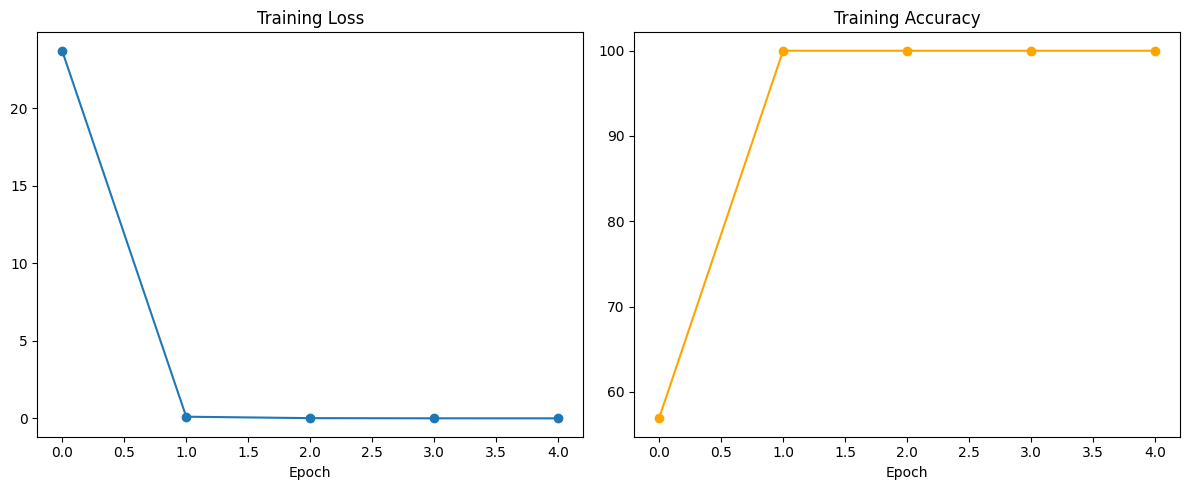

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# ------------------------------
# 1. DataLoader for MNIST
# ------------------------------
def get_data_loaders(batch_size=64):
    """
    Returns train and test DataLoader for MNIST dataset.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader


# ------------------------------
# 2. MoE Components
# ------------------------------

class GatingNetwork(nn.Module):
    """
    A gating network that outputs a distribution over experts
    and the top-k selected expert indices.
    """
    def __init__(self, in_channels, num_experts, top_k=1):
        super(GatingNetwork, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_experts)
        self.top_k = top_k
        # We'll store the last top_k indices for external use (placement training)
        self.last_topk_indices = None

    def forward(self, x):
        batch_size = x.size(0)
        pooled = self.global_pool(x).view(batch_size, -1)
        logits = self.fc(pooled)  # shape: (batch_size, num_experts)

        topk_logits, topk_indices = torch.topk(logits, self.top_k, dim=1)
        topk_weights = F.softmax(topk_logits, dim=1)

        # Create a sparse weights tensor (batch_size, num_experts) with zeros everywhere
        sparse_weights = torch.zeros_like(logits)
        sparse_weights.scatter_(1, topk_indices, topk_weights)

        # Store these indices for later usage (placement)
        self.last_topk_indices = topk_indices.detach()

        return sparse_weights, topk_indices


class Expert(nn.Module):
    """
    A simple CNN expert: Conv -> BN -> ReLU.
    """
    def __init__(self, in_channels, out_channels):
        super(Expert, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class MoEBlock(nn.Module):
    """
    Mixture-of-Experts block:
     - Gating network to select top_k experts
     - Weighted sum of expert outputs
     - Optional load-balance calculation
    """
    def __init__(self, in_channels, out_channels, num_experts=4, top_k=1):
        super(MoEBlock, self).__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.experts = nn.ModuleList([Expert(in_channels, out_channels)
                                      for _ in range(num_experts)])
        self.gate = GatingNetwork(in_channels, num_experts, top_k=top_k)
        self.out_conv = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # gating
        gate_weights, topk_indices = self.gate(x)

        # Compute each expert’s output
        expert_outputs = [expert(x) for expert in self.experts]
        # Stack along a new dimension => shape: (batch, num_experts, C, H, W)
        expert_stack = torch.stack(expert_outputs, dim=1)
        # Reshape gate weights => (batch, num_experts, 1, 1, 1)
        gate_weights = gate_weights.view(-1, self.num_experts, 1, 1, 1)
        # Weighted sum
        out = (expert_stack * gate_weights).sum(dim=1)

        # A little post-processing
        out = self.relu(self.bn(self.out_conv(out)))

        # (Optional) load balance loss or usage stats
        # We'll define them as placeholders so the signature remains
        batch_size = x.size(0)
        importance = gate_weights.squeeze().sum(0)
        diversity = (gate_weights.squeeze() > 0).float().sum(0)
        mean_importance = importance / batch_size
        mean_diversity = diversity / batch_size
        load_balance_loss = (mean_importance * mean_diversity).sum()

        # Expert distribution
        flat_indices = topk_indices.view(-1)
        counts = torch.bincount(flat_indices, minlength=self.num_experts)
        proportions = counts.float() / (batch_size * self.top_k)

        return out, load_balance_loss, proportions


class MoEClassifier(nn.Module):
    """
    A simple 2-layer MoE CNN for MNIST classification.
    """
    def __init__(self, num_classes=10, num_experts=4, top_k=1):
        super(MoEClassifier, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2)

        self.moe_block1 = MoEBlock(32, 64, num_experts, top_k)
        self.moe_block2 = MoEBlock(64, 128, num_experts, top_k)

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        lb_loss = 0.0
        gate_dists = []

        x = self.initial(x)
        x = self.pool(x)

        x, lb1, dist1 = self.moe_block1(x)
        lb_loss += lb1
        gate_dists.append(dist1)

        x = self.pool(x)
        x, lb2, dist2 = self.moe_block2(x)
        lb_loss += lb2
        gate_dists.append(dist2)

        x = self.global_pool(x).view(x.size(0), -1)
        logits = self.fc(x)

        return logits, lb_loss, gate_dists


# ------------------------------
# 3. Training and Testing (Base Model)
# ------------------------------
def train_base_model(model, device, train_loader, optimizer, criterion, epoch, aux_coeff):
    """
    Train loop for the MoE base model.
    """
    model.train()
    total_loss = 0.0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        logits, aux_loss, gate_dists = model(data)
        loss = criterion(logits, target) + aux_coeff * aux_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = logits.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]")
            print(f"  Loss: {loss.item():.6f}")

    avg_loss = total_loss / len(train_loader)
    accuracy = 100.0 * correct / len(train_loader.dataset)
    print(f"Epoch {epoch} - Base Model Train Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


def tes_base_model(model, device, test_loader, criterion):
    """
    Test loop for the MoE base model.
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total_samples = 0

    # For distribution stats
    gate1_total = torch.zeros(model.moe_block1.num_experts).to(device)
    gate2_total = torch.zeros(model.moe_block2.num_experts).to(device)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            batch_size = data.size(0)
            logits, _, gate_dists = model(data)

            loss = criterion(logits, target)
            test_loss += loss.item()
            pred = logits.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total_samples += batch_size

            # Accumulate gating distribution
            gate1_total += gate_dists[0] * batch_size
            gate2_total += gate_dists[1] * batch_size

    test_loss /= len(test_loader)
    accuracy = 100.0 * correct / total_samples
    print(f"Base Model Test - Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Print average distribution
    gate1_avg = (gate1_total / total_samples).cpu().numpy()
    gate2_avg = (gate2_total / total_samples).cpu().numpy()
    print("Block1 Dist (%):", " ".join([f"{100*d:.1f}" for d in gate1_avg]))
    print("Block2 Dist (%):", " ".join([f"{100*d:.1f}" for d in gate2_avg]))


# ------------------------------
# 4. Network Topology (Server <-> Devices)
# ------------------------------
# class NetworkTopology:
#     """
#     Minimal example: server is ID=0, devices are 1..N.
#     'comm_cost[i]' is cost from server to device i.
#     """
#     def __init__(self, num_devices=3, base_cost=5.0):
#         self.num_devices = num_devices
#         # cost[0] for server => 0
#         # cost[i] for device i => base_cost + small random
#         self.comm_cost = [0.0]
#         for i in range(1, num_devices+1):
#             cost_i = base_cost + np.random.rand() * 2.0
#             self.comm_cost.append(cost_i)

#     def get_cost(self, device_id):
#         return self.comm_cost[device_id]

# ------------------------------
# Modified Network Topology Class
# ------------------------------
class DynamicNetworkTopology:
    """
    Generates new random costs for server-device links every time reset() is called.
    Server is ID=0, devices are 1..N.
    """
    def __init__(self, num_devices=3, base_cost_range=(3.0, 7.0)):
        self.num_devices = num_devices
        self.base_cost_range = base_cost_range
        self.comm_cost = [0.0]  # Server cost is always 0
        self.reset()  # Initialize first topology

    def reset(self):
        """Generate new random costs for device links"""
        self.comm_cost = [0.0]  # Server
        for _ in range(self.num_devices):
            base_cost = np.random.uniform(*self.base_cost_range)
            self.comm_cost.append(base_cost)

    def get_cost(self, device_id):
        return self.comm_cost[device_id]

    def __repr__(self):
        return f"Topology: Server(0.0) -> Devices{self.comm_cost[1:]}"

# ------------------------------
# 5. Placement Selector Model
# ------------------------------
class PlacementSelector(nn.Module):
    """
    Predicts device placements for each selected expert.
    For demonstration: uses an embedding of (layer_id, expert_id) to
    produce a distribution over device_id in [0..num_devices].
    """
    def __init__(self, num_layers, num_experts, num_devices=3, embedding_dim=16):
        super(PlacementSelector, self).__init__()
        self.num_devices = num_devices
        # total_expert_keys = num_layers * num_experts
        self.num_layers = num_layers
        self.num_experts = num_experts

        # We create a single embedding to handle (layer_id, expert_id) => index
        self.embedding = nn.Embedding(num_layers * num_experts, embedding_dim)
        # Output distribution over [0..num_devices], i.e. (num_devices+1) possibilities
        self.fc = nn.Linear(embedding_dim, num_devices+1)

    def forward(self, layer_ids, expert_ids):
        """
        :param layer_ids:   (batch, top_k)
        :param expert_ids:  (batch, top_k)
        :return: device_probs => (batch, top_k, num_devices+1)
        """
        # Convert (layer_id, expert_id) to single index
        # index = layer_id * num_experts + expert_id
        combined_key = layer_ids * self.num_experts + expert_ids
        flat_key = combined_key.view(-1)
        emb = self.embedding(flat_key)  # shape: (batch*top_k, embedding_dim)
        logits = self.fc(emb)           # shape: (batch*top_k, num_devices+1)
        device_probs = F.softmax(logits, dim=-1)
        # Reshape
        B, K = combined_key.shape
        device_probs = device_probs.view(B, K, -1)
        return device_probs


# ------------------------------
# 6. Communication-Cost–Based Loss (Corrected)
# ------------------------------
def compute_placement_loss(device_probs, topology):
    """
    Returns differentiable loss based on expected cost, correct count, and total experts.
    """
    batch_size, top_k, num_dev_plus_one = device_probs.size()

    # Convert topology costs to a tensor on the correct device
    device_costs = torch.tensor(topology.comm_cost, device=device_probs.device, dtype=torch.float32)  # shape: (num_devices+1,)

    # Calculate expected cost for each expert (batch_size, top_k)
    expected_cost_per_expert = torch.einsum('bkd,d->bk', device_probs, device_costs)

    # The ideal cost is 0.0 (server), so loss is just the average expected cost
    loss = expected_cost_per_expert.mean()

    # Calculate accuracy: how often server (device 0) is chosen
    chosen_devices = torch.argmax(device_probs, dim=-1)  # (batch_size, top_k)
    correct = (chosen_devices == 0).sum().item()
    total_experts = batch_size * top_k

    return loss, correct, total_experts


# # ------------------------------
# # 7. Train the Placement Selector (Updated with corrected loss)
# # ------------------------------
# def train_placement_selector(base_model, placement_model, device,
#                              train_loader, optimizer, topology, num_layers):
#     """
#     Trains placement selector with differentiable loss.
#     """
#     base_model.eval()
#     placement_model.train()

#     total_loss = 0.0
#     total_correct = 0
#     total_experts = 0

#     for batch_idx, (data, target) in enumerate(train_loader):
#         data = data.to(device)
#         _ = target.to(device)  # not needed for placement training

#         optimizer.zero_grad()

#         # Forward pass to get top-k indices
#         with torch.no_grad():
#             _ = base_model(data)

#         # Get expert selections from both MoE blocks
#         topk_indices_block1 = base_model.moe_block1.gate.last_topk_indices
#         layer_ids_block1 = torch.zeros_like(topk_indices_block1, device=device)

#         topk_indices_block2 = base_model.moe_block2.gate.last_topk_indices
#         layer_ids_block2 = torch.ones_like(topk_indices_block2, device=device)

#         # Get placement predictions
#         device_probs_block1 = placement_model(layer_ids_block1, topk_indices_block1)
#         device_probs_block2 = placement_model(layer_ids_block2, topk_indices_block2)

#         # Calculate loss and accuracy metrics
#         loss_block1, correct1, total1 = compute_placement_loss(device_probs_block1, topology)
#         loss_block2, correct2, total2 = compute_placement_loss(device_probs_block2, topology)
#         loss = loss_block1 + loss_block2

#         # Update accuracy counters
#         total_correct += correct1 + correct2
#         total_experts += total1 + total2

#         # Backpropagation
#         loss.backward()
#         optimizer.step()

#         # Track loss
#         total_loss += loss.item()

#         # Print batch stats
#         if batch_idx % 100 == 0 and total1 + total2 > 0:
#             batch_acc = ((correct1 + correct2) / (total1 + total2)) * 100.0
#             print(f"[{batch_idx}/{len(train_loader)}] Placement Loss: {loss.item():.4f}, Accuracy: {batch_acc:.2f}%")

#     # Calculate final metrics
#     avg_loss = total_loss / len(train_loader)
#     overall_acc = (total_correct / total_experts) * 100.0 if total_experts > 0 else 0.0
#     print(f"Placement Training - Avg Cost Loss: {avg_loss:.4f}, Accuracy: {overall_acc:.2f}%")

# ------------------------------
# Modified Training Function
# ------------------------------
def train_placement_selector(base_model, placement_model, device,
                             train_loader, optimizer, topology_config,
                             num_layers, num_epochs):
    """
    Now handles dynamic topology changes between epochs
    """
    # Track metrics across epochs
    epoch_losses = []
    epoch_accuracies = []
    topology_samples = []

    for epoch in range(1, num_epochs+1):
        # Create new topology for this epoch
        current_topology = DynamicNetworkTopology(**topology_config)
        topology_samples.append(current_topology)
        print(f"\n=== Epoch {epoch} ===")
        print(current_topology)

        # Training loop with current topology
        base_model.eval()
        placement_model.train()

        total_loss = 0.0
        total_correct = 0
        total_experts = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            _ = target.to(device)

            optimizer.zero_grad()

            # Forward pass to get top-k indices
            with torch.no_grad():
                _ = base_model(data)

            # Get expert selections from both MoE blocks
            topk_indices_block1 = base_model.moe_block1.gate.last_topk_indices
            layer_ids_block1 = torch.zeros_like(topk_indices_block1, device=device)

            topk_indices_block2 = base_model.moe_block2.gate.last_topk_indices
            layer_ids_block2 = torch.ones_like(topk_indices_block2, device=device)

            # Get placement predictions
            device_probs_block1 = placement_model(layer_ids_block1, topk_indices_block1)
            device_probs_block2 = placement_model(layer_ids_block2, topk_indices_block2)

            # Calculate loss and accuracy metrics
            loss_block1, correct1, total1 = compute_placement_loss(device_probs_block1, current_topology)
            loss_block2, correct2, total2 = compute_placement_loss(device_probs_block2, current_topology)
            loss = loss_block1 + loss_block2

            # Update counters
            total_correct += correct1 + correct2
            total_experts += total1 + total2
            total_loss += loss.item()

            # Backpropagation
            loss.backward()
            optimizer.step()

        # Calculate epoch metrics
        avg_loss = total_loss / len(train_loader)
        accuracy = (total_correct / total_experts) * 100 if total_experts > 0 else 0
        epoch_losses.append(avg_loss)
        epoch_accuracies.append(accuracy)

        print(f"Epoch {epoch} - Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

        # Test on new unseen topology
        test_topology = DynamicNetworkTopology(**topology_config)
        test_placement_selector(placement_model, base_model, device,
                               train_loader, test_topology)

    return epoch_losses, epoch_accuracies, topology_samples


# ------------------------------
# Test Function with Dynamic Topology
# ------------------------------
def test_placement_selector(placement_model, base_model, device,
                           test_loader, topology):
    """Evaluate placement selector on a new topology"""
    placement_model.eval()
    base_model.eval()

    total_correct = 0
    total_experts = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)

            # Forward pass through base model
            _ = base_model(data)

            # Get expert selections
            topk_indices_block1 = base_model.moe_block1.gate.last_topk_indices
            layer_ids_block1 = torch.zeros_like(topk_indices_block1, device=device)

            topk_indices_block2 = base_model.moe_block2.gate.last_topk_indices
            layer_ids_block2 = torch.ones_like(topk_indices_block2, device=device)

            # Get placements
            device_probs_block1 = placement_model(layer_ids_block1, topk_indices_block1)
            device_probs_block2 = placement_model(layer_ids_block2, topk_indices_block2)

            # Calculate accuracy
            _, correct1, total1 = compute_placement_loss(device_probs_block1, topology)
            _, correct2, total2 = compute_placement_loss(device_probs_block2, topology)

            total_correct += correct1 + correct2
            total_experts += total1 + total2

    accuracy = (total_correct / total_experts) * 100 if total_experts > 0 else 0
    print(f"Test on {topology} => Accuracy: {accuracy:.2f}%")


# ------------------------------
# 8. Main: Train base model, then freeze & train placement
# ------------------------------
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Prepare data
    train_loader, test_loader = get_data_loaders(batch_size=64)

    # -------------------------
    # A) Train the base MoE model
    # -------------------------
    num_experts = 8
    top_k = 2
    base_model = MoEClassifier(num_experts=num_experts, top_k=top_k).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(base_model.parameters(), lr=0.001)
    aux_coeff = 0.01
    print("\n--- Training Base MoE Model ---")
    base_epochs = 1  # keep it small for demo
    for epoch in range(1, base_epochs+1):
        train_base_model(base_model, device, train_loader, optimizer, criterion, epoch, aux_coeff)
        tes_base_model(base_model, device, test_loader, criterion)

    # Save the trained model
    base_model_path = "moe_mnist_balanced.pth"
    torch.save(base_model.state_dict(), base_model_path)
    print(f"Base model saved to {base_model_path}.")

    # -------------------------
    # B) Load the pretrained MoE in a frozen state
    # -------------------------
    frozen_model = MoEClassifier(num_experts=num_experts, top_k=top_k).to(device)
    frozen_model.load_state_dict(torch.load(base_model_path, map_location=device))

    for param in frozen_model.parameters():
        param.requires_grad = False

    # -------------------------
    # C) Create a topology and the PlacementSelector
    # -------------------------
    # Create placement model with dynamic topology
    topology_config = {
        "num_devices": 100,
        "base_cost_range": (10,100)  # Random costs between 2-8 each epoch
    }

    placement_model = PlacementSelector(num_layers=2,
                                       num_experts=num_experts,
                                       num_devices=topology_config["num_devices"],
                                       embedding_dim=16).to(device)

    placement_optimizer = optim.Adam(placement_model.parameters(), lr=1e-3)

    # -------------------------
    # D) Train the placement selector
    # -------------------------
    # Train with dynamic topologies
    print("\n--- Training Placement Selector with Dynamic Topologies ---")
    losses, accs, topologies = train_placement_selector(
        frozen_model, placement_model, device,
        train_loader, placement_optimizer,
        topology_config=topology_config,
        num_layers=2,
        num_epochs=5
    )

    # Save model and visualize training
    placement_path = "dynamic_placement_selector.pth"
    torch.save(placement_model.state_dict(), placement_path)
    print(f"Placement selector saved to {placement_path}.")

    # Plot training progress
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses, marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")

    plt.subplot(1, 2, 2)
    plt.plot(accs, marker='o', color='orange')
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Make sure we're not cluttering with old plots, etc.
    # You can remove or comment out these lines if desired
    if not os.path.exists("./data"):
        os.makedirs("./data")
    main()
